In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Simulate ball throwing and generate Observations

In [12]:
from ball_throwing_simulator import BallThrowingSimulator

(61, 4, 1) (61, 2, 1)


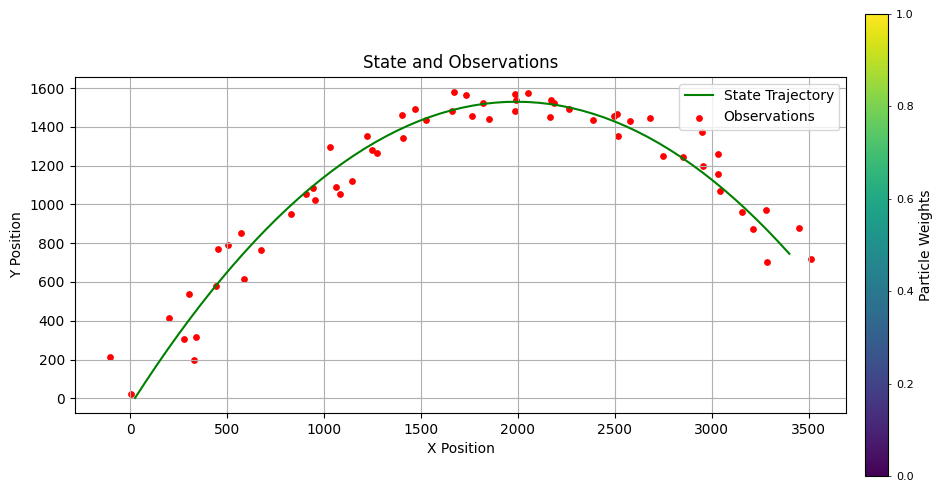

In [13]:
ball_num = 1
# init_state = np.array([[0, 0], [50,30], [100,80], [100,80]])  # Initial state: [x, y, vx, vy]
simulator = BallThrowingSimulator(delta_t=0.5, ball_num=ball_num, observation_variance=[10, 10])
# Simulate the motion and observations
states, observations = simulator.simulate(time=30)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 3000]$$
$$V_x, V_y \in [0, 200]$$

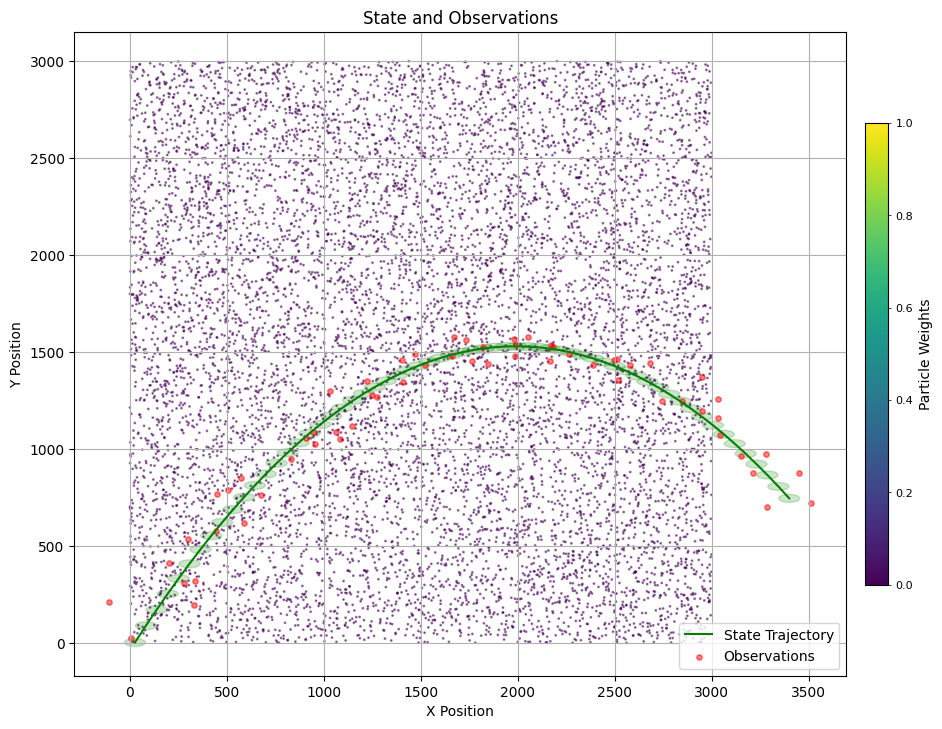

In [43]:
from partickle_filter import ParticleFilter
# initialize 1000 random particles
pf = ParticleFilter(10000)

init_particles, init_weights = pf.snaps[0]

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations, NormalObservation.R)
plt.show()

(10000, 4, 1)
[3.83103652e-016 2.17621300e-081 2.47075159e-124 0.00000000e+000
 2.32328689e-039 1.99245023e-169 1.05238510e-034 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
new weights sum: 0.00011653211783635622
[3.28753703e-012 1.86747915e-077 2.12023229e-120 0.00000000e+000
 1.99368803e-035 1.70978634e-165 9.03085882e-031 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


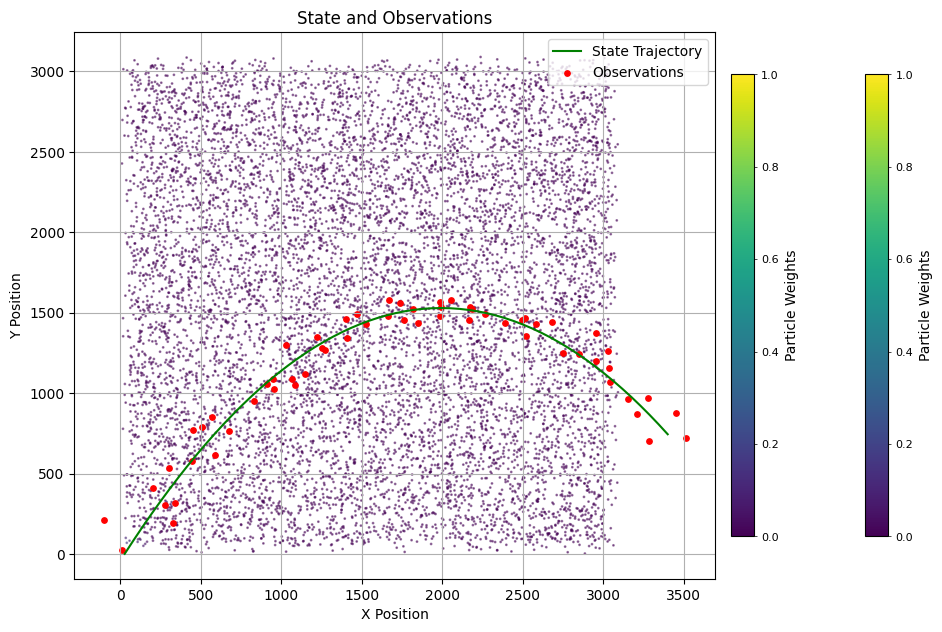

[6.42208029e-08 6.42208029e-08 6.42208029e-08 6.42208029e-08
 6.42208029e-08 6.42208029e-08 6.42208029e-08 6.42208029e-08
 6.42208029e-08 6.42208029e-08]
new weights sum: 0.011859275871123738
[5.41523813e-06 5.41523813e-06 5.41523813e-06 5.41523813e-06
 5.41523813e-06 5.41523813e-06 5.41523813e-06 5.41523813e-06
 5.41523813e-06 5.41523813e-06]


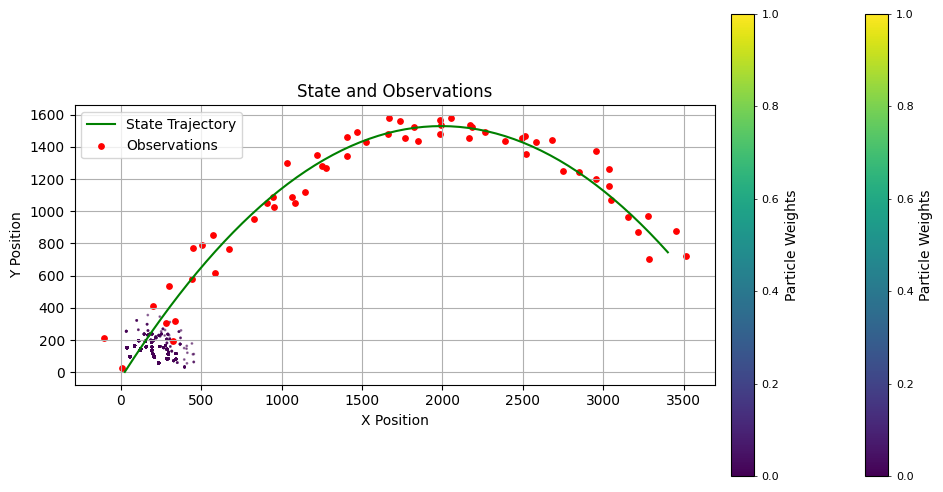

[1.07073839e-05 1.07073839e-05 1.07073839e-05 1.07073839e-05
 1.07073839e-05 1.07073839e-05 1.07073839e-05 2.89508837e-05
 2.89508837e-05 1.45490805e-05]
new weights sum: 0.012325970456550874
[0.00086868 0.00086868 0.00086868 0.00086868 0.00086868 0.00086868
 0.00086868 0.00234877 0.00234877 0.00118036]


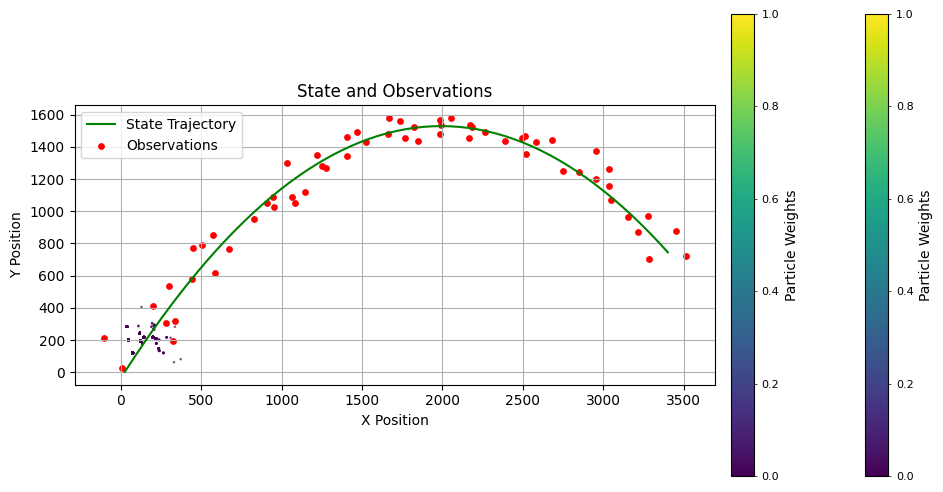

[2.57901317e-07 2.57901317e-07 2.57901317e-07 2.57901317e-07
 2.57901317e-07 2.57901317e-07 2.57901317e-07 2.57901317e-07
 2.57901317e-07 2.57901317e-07]
new weights sum: 0.08756570445490136
[2.94523202e-06 2.94523202e-06 2.94523202e-06 2.94523202e-06
 2.94523202e-06 2.94523202e-06 2.94523202e-06 2.94523202e-06
 2.94523202e-06 2.94523202e-06]


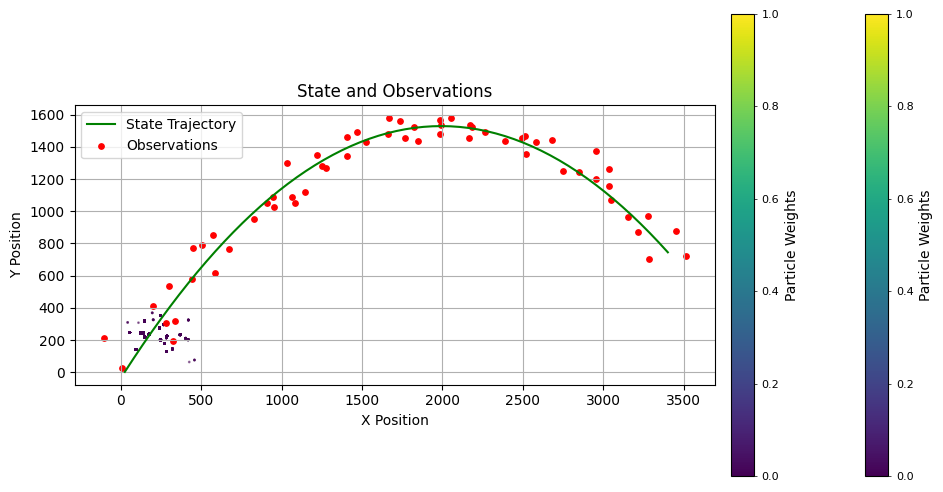

[9.74751668e-08 1.33337867e-06 1.33337867e-06 1.33337867e-06
 1.33337867e-06 1.33337867e-06 1.33337867e-06 1.33337867e-06
 1.33337867e-06 1.33337867e-06]
new weights sum: 0.10725153115695185
[9.08846389e-07 1.24322577e-05 1.24322577e-05 1.24322577e-05
 1.24322577e-05 1.24322577e-05 1.24322577e-05 1.24322577e-05
 1.24322577e-05 1.24322577e-05]


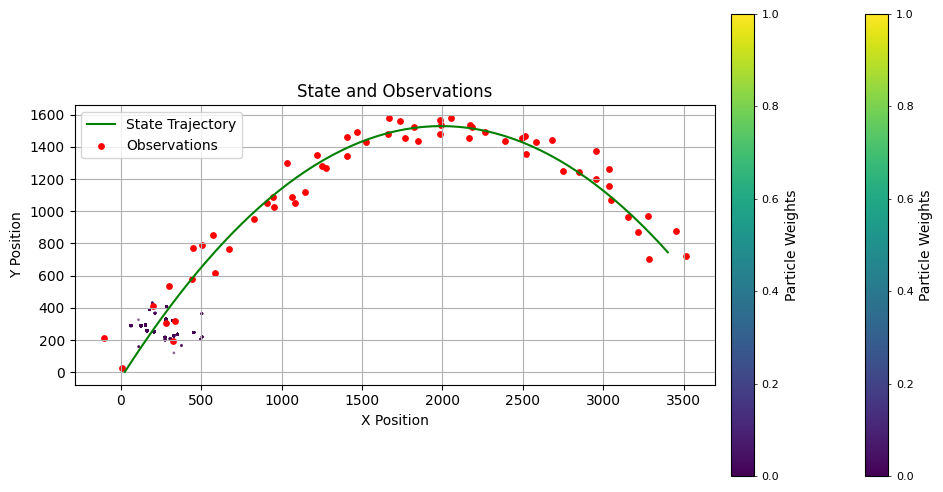

[3.22586473e-11 3.22586473e-11 1.35246905e-07 1.35246905e-07
 1.35246905e-07 1.35246905e-07 1.35246905e-07 1.35246905e-07
 1.35246905e-07 1.35246905e-07]
new weights sum: 0.1116242736866418
[2.88993121e-10 2.88993121e-10 1.21162629e-06 1.21162629e-06
 1.21162629e-06 1.21162629e-06 1.21162629e-06 1.21162629e-06
 1.21162629e-06 1.21162629e-06]


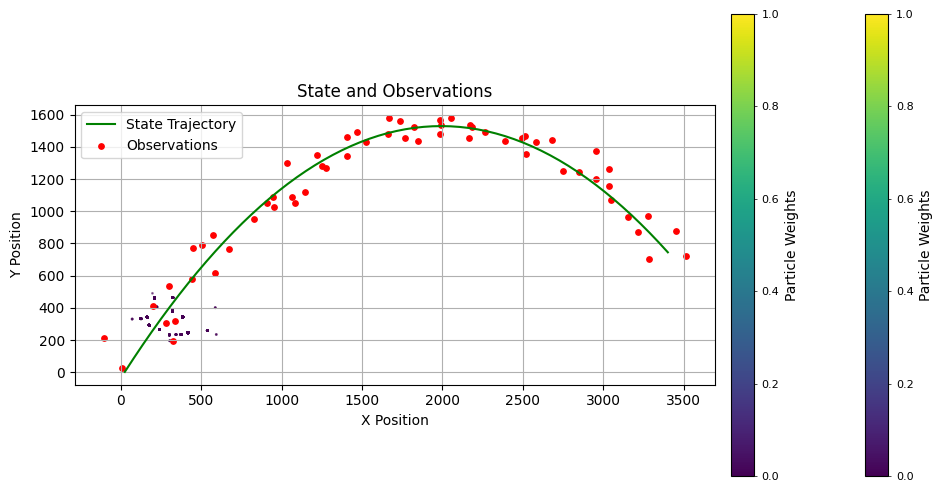

[4.77378097e-07 4.77378097e-07 4.77378097e-07 4.77378097e-07
 4.77378097e-07 4.77378097e-07 4.77378097e-07 4.77378097e-07
 4.77378097e-07 4.77378097e-07]
new weights sum: 0.08935869828467569
[5.3422678e-06 5.3422678e-06 5.3422678e-06 5.3422678e-06 5.3422678e-06
 5.3422678e-06 5.3422678e-06 5.3422678e-06 5.3422678e-06 5.3422678e-06]


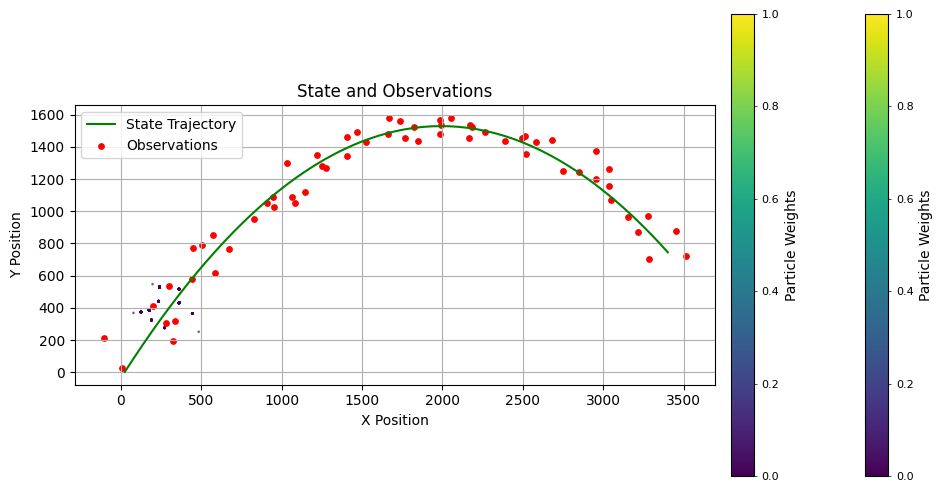

[1.45640111e-11 1.45640111e-11 1.45640111e-11 1.45640111e-11
 1.45640111e-11 1.45640111e-11 1.45640111e-11 1.45640111e-11
 1.45640111e-11 1.45640111e-11]
new weights sum: 0.0016272925424447948
[8.949842e-09 8.949842e-09 8.949842e-09 8.949842e-09 8.949842e-09
 8.949842e-09 8.949842e-09 8.949842e-09 8.949842e-09 8.949842e-09]


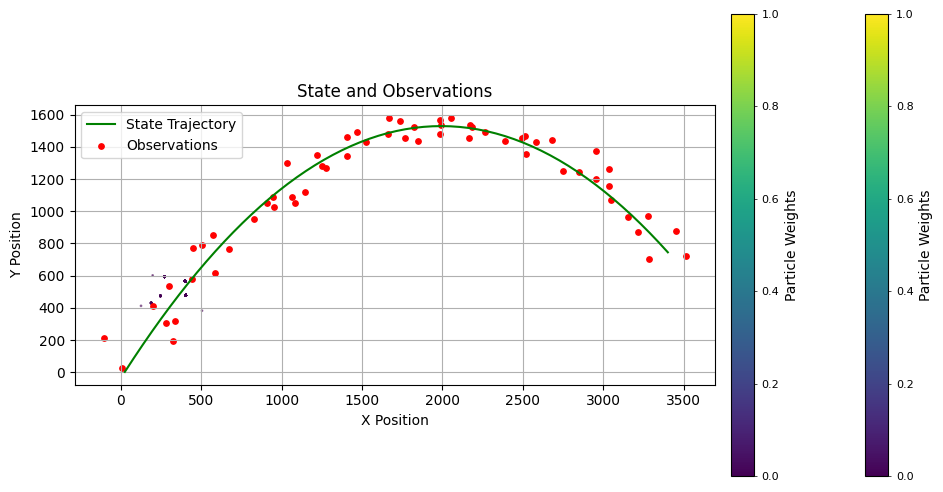

[1.86613292e-05 1.86613292e-05 1.86613292e-05 1.86613292e-05
 1.86613292e-05 1.86613292e-05 1.86613292e-05 1.86613292e-05
 1.86613292e-05 1.86613292e-05]
new weights sum: 0.15808480130008895
[0.00011805 0.00011805 0.00011805 0.00011805 0.00011805 0.00011805
 0.00011805 0.00011805 0.00011805 0.00011805]


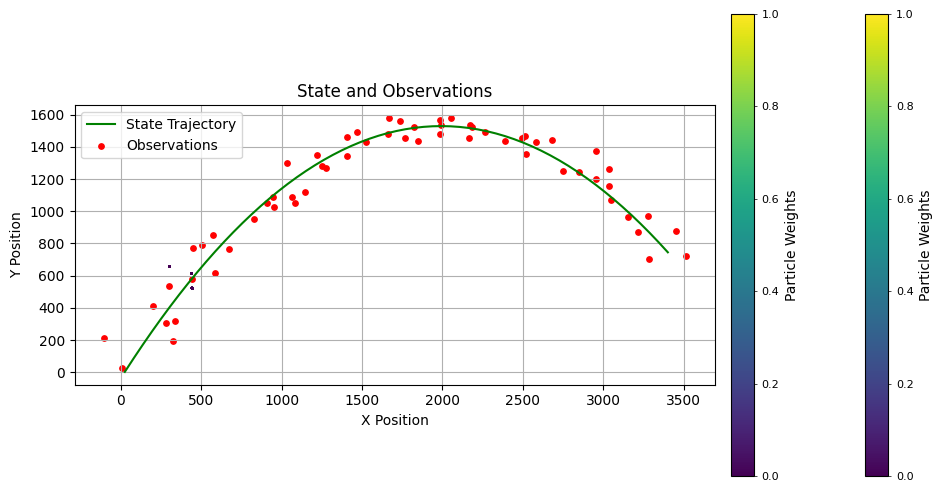

[1.68532382e-08 1.68532382e-08 1.68532382e-08 1.68532382e-08
 1.68532382e-08 1.68532382e-08 1.68532382e-08 1.68532382e-08
 1.68532382e-08 1.68532382e-08]
new weights sum: 0.007994611562646232
[2.10807468e-06 2.10807468e-06 2.10807468e-06 2.10807468e-06
 2.10807468e-06 2.10807468e-06 2.10807468e-06 2.10807468e-06
 2.10807468e-06 2.10807468e-06]


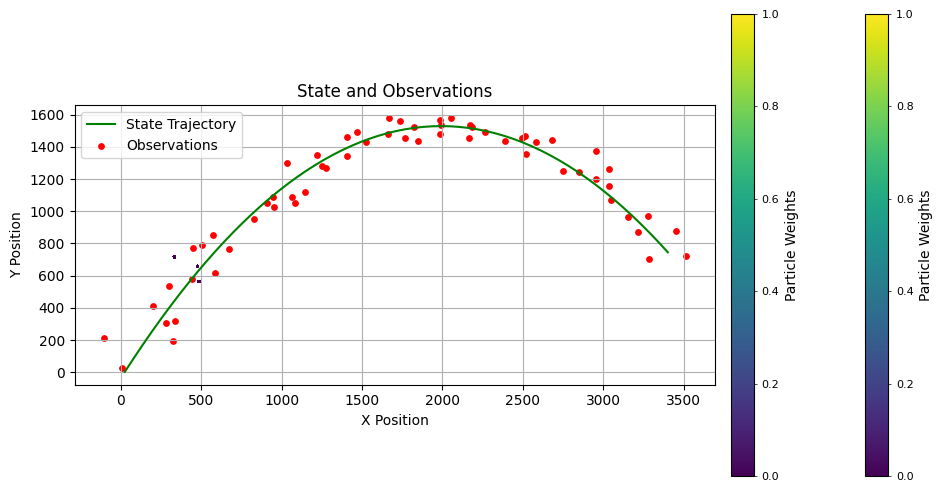

In [15]:
particles, weights = pf.particles, pf.weights
print(particles.shape)

for i in range(10):
    particles, weights = pf.update(particles, weights, observations[i,:])
    fig, ax = plt.subplots(figsize=(12, 12))
    # ax.set_xlim(0, 3000)
    # ax.set_ylim(0, 3000)
    ax.set_title('Initial Particles')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    plot_particles(ax, particles, weights)
    plot_observations(ax, states, observations)
    plt.show()